# Proyección de las trayectorias con cMDS

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
import pickle
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Carga de los datos de referencia

In [2]:
prot_name = 'cdk2'

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
pocket_residues = get_pocket_residues(sep=",")

In [5]:
mask_pisani = F"(:{pisiani_residues})&(@CA)"

In [6]:
# Carga de la trayectoria de estructuras cristalograficas
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

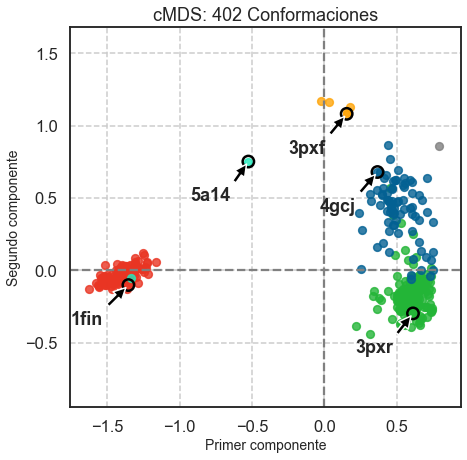

In [8]:
mds_plot = mds_pisani_402
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_plot[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_plot[0][0], mds_plot[0][1], 
                      xytext_delta=[0.4, 0.3], s=130)

## Proyección de trayectorias
### Cargamos el json con las proyecciones

In [9]:
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'mds_all_traj_projections.obj')
#
with open(path_mds_obj, 'rb') as f:
    dic_trajs = pickle.load(f)

## Visualización con bokeh

In [202]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ResetTool, PanTool, WheelZoomTool, ColumnDataSource, Span, HoverTool, LabelSet

In [94]:
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from matplotlib import cm

['#0000ff', '#0080bf', '#00ff80']

In [98]:
cmap = cm.get_cmap('Spectral_r', 3*2)
[rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

['#5e4fa2', '#66c2a5', '#e6f598', '#fee08b', '#f46d43', '#9e0142']

In [195]:
idx_4fku = df_prot.index.get_loc('4fku')
idx_1fin = df_prot.index.get_loc('1fin')

mds_plot[0][0][[idx_4fku, idx_1fin]]
mds_plot[0][1][[idx_4fku, idx_1fin]]

array([ 0.2550182 , -0.10097356])

In [197]:
df_prot.index.to_series().apply(lambda x: x.upper())[[idx_4fku, idx_1fin]]

4fku    4FKU
1fin    1FIN
dtype: object

In [213]:
# tools reference
HOVER = HoverTool(names=["ref"])
TOOLTIPS = [
    ("index", "$index"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label")]
TOOLS = ['pan', 'wheel_zoom', HOVER, ResetTool()]

f = figure(plot_width = 900, plot_height = 800,
           title = 'Proyección de las trayectorias',
           match_aspect=True, active_scroll='wheel_zoom',
           tooltips = TOOLTIPS, tools = TOOLS)


# Styling del plot
f.title.text_font_size = '2em'

# Axis
f.axis.axis_line_width = 3.3
f.axis.major_label_text_font_size = '1.1em'
f.axis.major_label_text_font_style = 'bold'

# Labels
f.axis.axis_label_text_font_size = '1.4em'
f.xaxis.axis_label = 'Dimensión 1'
f.yaxis.axis_label = 'Dimensión 2'

# Grid

# Plot de la referencia de pisani
ref_pisani = ColumnDataSource({
    'x': mds_plot[0][0], 'y': mds_plot[0][1]})

# Datasource referencia

conformation_labels = df_prot.Labels_conf
conf_labels = conformation_labels.unique()

ref_pisani = ColumnDataSource(data = dict(
    x = mds_plot[0][0],
    y = mds_plot[0][1],
    pdb_id = df_prot.index.to_series().apply(lambda x: x.upper()),
    conf_label = conformation_labels,
))

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='grey', line_width=2, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='grey', line_width=2, line_dash='dashed')
f.renderers.extend([vline, hline])

# Proyección de referencia
f.scatter('x', 'y', source = ref_pisani, name = 'ref',
          size = 10, alpha = 0.8, color = '#cccccc', 
          line_color = '#aaaaaa')

# tools location
f.toolbar_location = 'above'
# hide boke logo
f.toolbar.logo = None

# Proyección de un sistema
interval = 10
palettes = {'1fin': 'Spectral_r', '4fku': 'Spectral'}
for conf, system in dic_trajs['cdk2'].items():
    palette = palettes[conf]
    cmap = cm.get_cmap(palette, len(system)*3)
    colors = [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    for c, method in enumerate(system.keys()):
        if system[method] is not None:
            for i, j in system[method].items():
                system_legend = F'{conf}: {method}'
                f.scatter(x = j[0][::interval], y = j[1][::interval], 
                          color = colors[c],  alpha = 0.8, 
                          muted_color = colors[c], muted_alpha=0.01,
                          name = system_legend, legend = system_legend, size = 5, 
                          marker = 'diamond')
                
idx_4fku = df_prot.index.get_loc('4fku')
idx_1fin = df_prot.index.get_loc('1fin')
# plotting labels
ref_conformations = ColumnDataSource(data = dict(
            x= mds_plot[0][0][[idx_4fku, idx_1fin]],
            y = mds_plot[0][1][[idx_4fku, idx_1fin]],
            pdb_id = df_prot.index.to_series().apply(lambda x: x.upper())[[idx_4fku, idx_1fin]],
            conf_label = conformation_labels[[idx_4fku, idx_1fin]],
    ))

# Proyección de referencia
f.scatter('x', 'y', source = ref_conformations,
          size = 10, color = '#E3E305', line_width = 3,
          line_color = 'black')
labels = LabelSet(x = 'x', y= 'y', text = 'pdb_id', 
                  source = ref_conformations, 
                  background_fill_color = 'white',
                  background_fill_alpha = 0.8,
                  x_offset=5, y_offset=5,
                  text_font_style = 'bold')
f.add_layout(labels)

f.legend.click_policy="mute"
f.legend.location = 'top_left'

output_notebook()
show(f)

Loading BokehJS ...